In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import analysis

packets = analysis.parse_packet_file('data/all.txt')
packets += analysis.parse_packet_file('data/temp_basals.txt')

# Select valid packets
packets = filter(lambda x: x.is_valid() and x.body_len == 3, packets)


In [2]:
print packets[0]

2016-06-26T20:33:28.412197 ID1:1f01482a PTYPE:PDM SEQ:13 ID2:1f01482a B9:10 BLEN:3 MTYPE:0e01 BODY:00802c CRC:88


In [3]:
print packets[0].tx_data().encode('hex')

1f01482aad1f01482a10030e0100802c88


In [8]:
def split_parts(data, idx):
    return (ord(data[idx]), (data[4:idx] + data[idx+1:-3]).encode('hex'), data[-3:-1].encode('hex'))

def get_parts_df(pos, packets):
    parts = [split_parts(p.tx_data(), pos) for p in packets] 
    parts_df = pd.DataFrame(parts, columns=["byte", "other", "hash"])
    parts_df.drop_duplicates(inplace=True)
    return parts_df

def analyze_parts(parts_df):
    # Number of times byte changes independently of 'other'
    independent_change_count = parts_df.groupby(['other']).count()['byte'].max() - 1
    # Max number of times byte changed independently of hash
    # Higher number here means not likely to be included in hash
    hash_independent_change_count = parts_df.groupby(['hash', 'other']).count()['byte'].max() - 1
    # Number of times hash changed dependent on byte
    dependent_change_count = parts_df.groupby(['other']).count()['hash'].max() - 1
    return (independent_change_count, hash_independent_change_count, dependent_change_count)

plen = len(packets[0].tx_data())
# For all bytes except the last three (2-byte hash and crc8)
stats = [analyze_parts(get_parts_df(i, packets)) for i in range(4, plen-3)]
stats = pd.DataFrame(stats, columns=['ichange', 'hichange', 'dchange'])

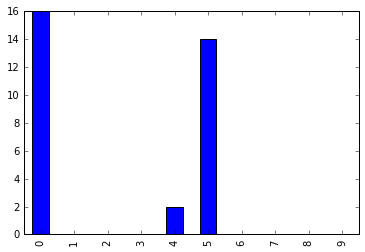

In [9]:
stats['ichange'].plot.bar()

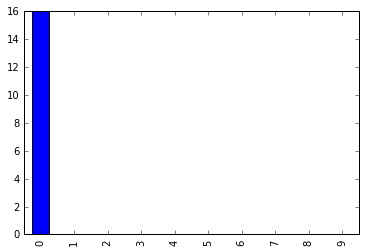

In [10]:
stats['hichange'].plot.bar()

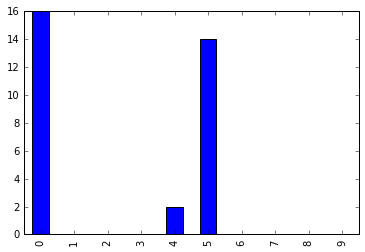

In [11]:
stats['dchange'].plot.bar()